In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Patch to remove log values from the colorbar on the hexbin plot
from matplotlib.ticker import LogFormatter 
class LogFormatterHB(LogFormatter):
     def __call__(self, v, pos=None):
         vv = self._base ** v
         return LogFormatter.__call__(self, vv, pos) 

# Convert latitude, longitude pairs to distance in meters
def pythagoras(lat_in, lon_in):
    lat = np.array(lat_in)
    lon = np.array(lon_in)
    
    lat *= np.pi/180
    lon *= np.pi/180
    
    lon1 = lon[0:-1]
    lon2 = lon[1:]
    
    lat1 = lat[0:-1]
    lat2 = lat[1:]
    
    x = (lon2-lon1) * np.cos((lat1+lat2)/2)
    y = lat2-lat1
    
    d = np.sqrt(x**2 + y**2) * 6371*1000
    return d


# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files
    

In [3]:
#%% Read in data 

full_files = get_files('data')

print ("Reading in the .txt files...")

data = []
for index, file_path in enumerate(full_files):
    data.append(pd.read_csv(file_path, infer_datetime_format=True, header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude']))

data = pd.concat(data, ignore_index=True)

print ("Size of data frame: ", data.shape)
print ("%.1f million rows" % (data.shape[0]/1.0e6))

# Drop duplicates and NAs 
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

Reading in the .txt files...
Size of data frame:  (17662984, 4)
17.7 million rows


In [4]:
#%% Compute Time Intervals
print ("Computing time intervals...")
grouped = data.sort_values('date_time').groupby('taxi_id')['date_time']

time_intervals = []
for group_id, times in grouped:
    time_intervals.append(times.diff())
    
time_intervals = pd.concat(time_intervals)
time_intervals.dropna(inplace=True)
time_intervals /= np.timedelta64(1,'s') # Divide by 1 second, for float64 data


print ("Average sample interval: %.0f secs" % time_intervals[time_intervals < 1e4].mean())
time_intervals /= 60    # Convert to minutes

Computing time intervals...
Average sample interval: 220 secs


In [5]:
#%% Compute Distance Intervals
print ("Computing distance intervals...")
grouped = data.sort_values('date_time').groupby('taxi_id')

distances = []
for g in grouped:
    # Distances are given in meters
    distances.append(pd.DataFrame(pythagoras(g[1].latitude.values, g[1].longitude.values)))

distances = pd.concat(distances)

print ("Total trajectory distance: %.0f million km" % (distances[distances[0] < 1e5][0].sum()/1e9))

print ("Average distance between samples: %.0f m" % (distances[(distances[0] < 1e5)][0].mean()))

Computing distance intervals...
Total trajectory distance: 12 million km
Average distance between samples: 727 m


Plotting time intervals...


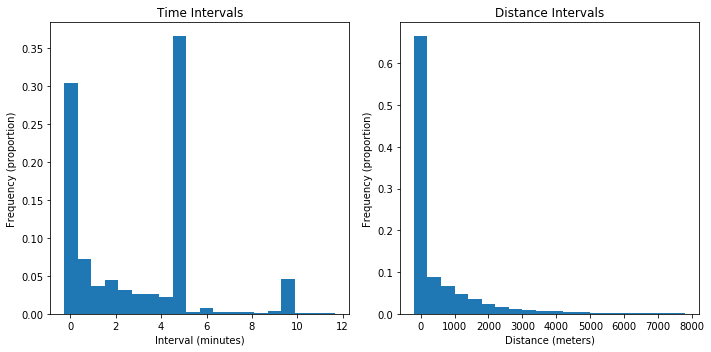

In [6]:
#%% Plotting: Time -- plots a histogram time intervals with 
#                     proportions summing to 1
print ("Plotting time intervals...")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].set_xlabel('Interval (minutes)')
axes[0].set_ylabel('Frequency (proportion)')
axes[0].set_title('Time Intervals')

hist, bins = np.histogram(time_intervals[(time_intervals > 0) & (time_intervals < 12)].astype(np.ndarray), bins=20)
axes[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

distances.dropna(inplace=True)

#% Plotting: Distance -- plots a normed histogram of distance intervals
hist, bins = np.histogram(distances[distances[0] < 8000][0].values, bins=20)

axes[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Frequency (proportion)')
axes[1].set_title('Distance Intervals')

fig.tight_layout()

Plotting position density...


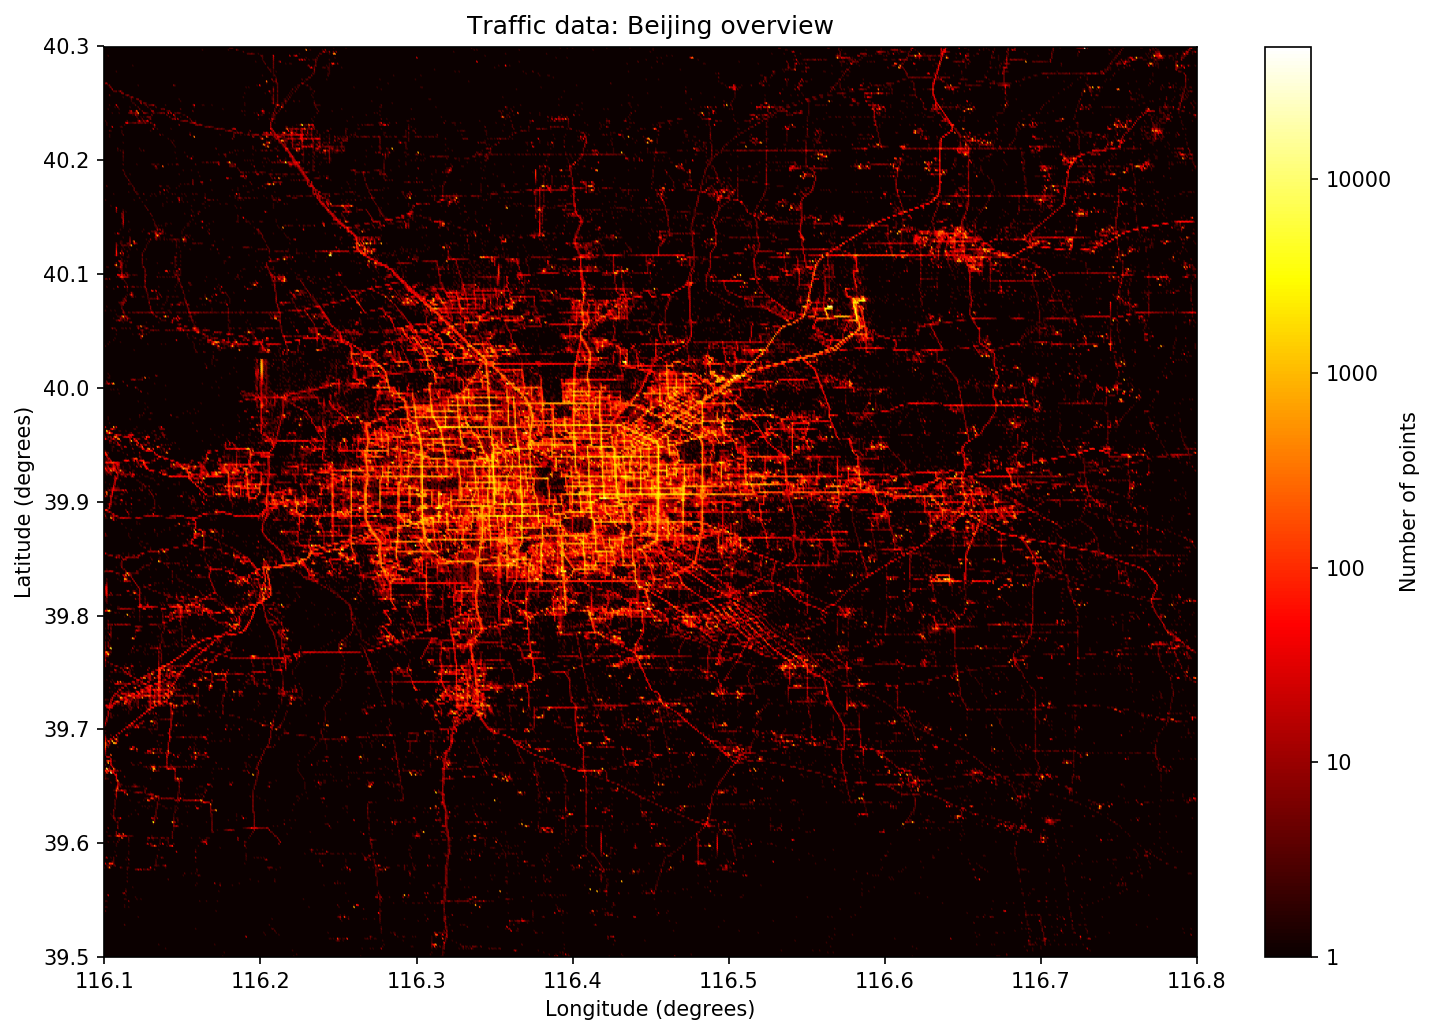

In [7]:
#%% Plot position density -- Overview 

print ("Plotting position density...")
xmin, xmax = 116.1, 116.8
ymin, ymax = 39.5, 40.3

window = data[(xmin < data.longitude) & (data.longitude < xmax) & (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data: Beijing overview")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

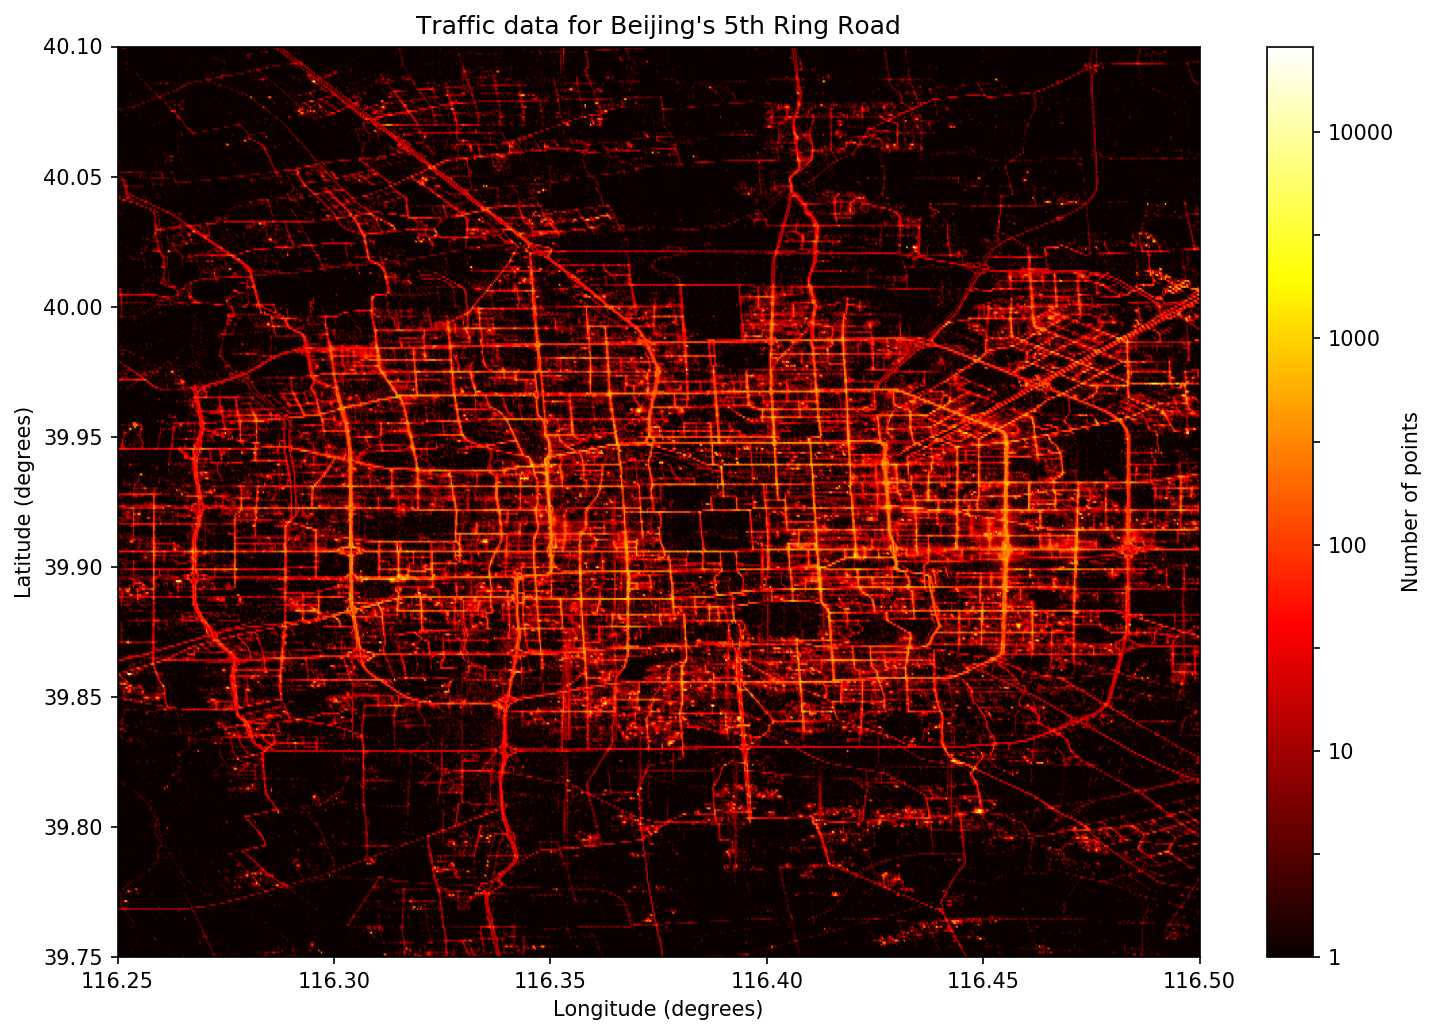

In [8]:
# Location details
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data for Beijing's 5th Ring Road")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

Taxi data for Taxi ID: 639986
Start date and time:  2008-02-02 13:34:04
Duration: 0 days 00:02:36


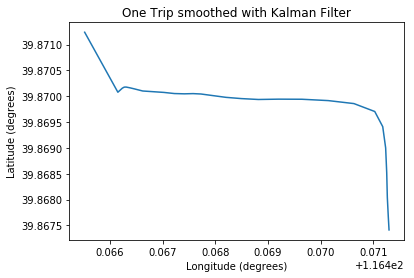

In [9]:
#%% Kalman Filter and plot taxi trip
one_taxi = data[data.taxi_id == 1131]

start_index = 38
end_index = 69

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0], n_dim_obs=2, n_dim_state=2)

kf = kf.em(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("One Trip smoothed with Kalman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

print ("Taxi data for Taxi ID: %d" % one_taxi.index.values[0])
print ("Start date and time: ", one_taxi.date_time[one_taxi.index.values[start_index]])
print ("Duration:", one_taxi.date_time[one_taxi.index.values[end_index]] - one_taxi.date_time[one_taxi.index.values[start_index]])

Taxi data for Taxi ID: 639986
Start date and time:  2008-02-02 13:30:49
Duration: 0 days 01:13:10


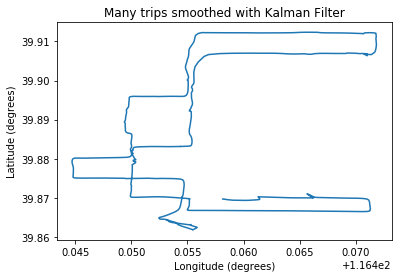

In [10]:
#%% Kalman Filter and plot results
one_taxi = data[data.taxi_id == 1131]

start_index = 0
end_index = 800

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0], n_dim_obs=2, n_dim_state=2)

kf = kf.em(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("Many trips smoothed with Kalman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
print ("Taxi data for Taxi ID: %d" % one_taxi.index.values[0])
print ("Start date and time: ", one_taxi.date_time[one_taxi.index.values[start_index]])
print ("Duration:", one_taxi.date_time[one_taxi.index.values[end_index]] - one_taxi.date_time[one_taxi.index.values[start_index]])